In [1]:
import matplotlib.pyplot as plt
import numpy as np
import classy

from astropy.cosmology import Planck18_arXiv_v2 as Planck

kmax = 500

h = Planck.h
class LCDM:
    h = h
    H0 = Planck.H0.value
    omega_b = Planck.Ob0 * h ** 2
    omega_cdm = (Planck.Om0 - Planck.Ob0) * h ** 2
    omega_nu = Planck.Onu0
    omega_k = Planck.Ok0

    m_ncdm = sum(Planck.m_nu).value
    Neff = Planck.Neff
    N_ncdm = 1
    N_ur = Planck.Neff - N_ncdm

    Tcmb = Planck.Tcmb0.value
    A_s = 2.097e-9
    tau_reio = 0.0540
    n_s = 0.9652
    YHe = 0.24537116583825905
    reion_exponent = 1.5
    reion_width = 0.5

    @classmethod
    def class_params(self):
        return {
            'h': self.h, 'omega_b': self.omega_b, 'omega_cdm': self.omega_cdm,
            'Omega_k': self.omega_k, 'N_ur': self.N_ur, 'N_ncdm': self.N_ncdm,
            'm_ncdm': self.m_ncdm, 'A_s': self.A_s, 'n_s': self.n_s,
            'T_cmb': self.Tcmb, 'tau_reio': self.tau_reio, 'YHe': self.YHe,
            'reionization_exponent': self.reion_exponent,
            'reionization_width': self.reion_width, 'P_k_max_1/Mpc': kmax,
            'output': 'dTk,mPk,tCl',
        }



In [2]:
m_dmeff = 1.0e-3  # GeV
sigma_dmeff = 1e-41  # cm^2
# sigma_dmeff = 1e-40
Vrel_dmeff = 30 # km/s at z ~ 1010

z_pk = 60.

params_lcdm = LCDM.class_params()
params_lcdm.update({'z_pk': z_pk})

params_idm = dict(params_lcdm)
params_idm.update({
    'omega_dmeff': 0.12038, 'omega_cdm': 1e-10, 'm_dmeff': m_dmeff,
    'sigma_dmeff': sigma_dmeff, 'npow_dmeff': -4, 'Vrel_dmeff': Vrel_dmeff
})


cl_lcdm = classy.Class()
cl_lcdm.set(params_lcdm)
cl_lcdm.compute()

cl_idm = classy.Class()
cl_idm.set(params_idm)
cl_idm.compute()


In [3]:
import pyccl as ccl


cosmo_lcdm = ccl.Cosmology(Omega_c=params_lcdm['omega_cdm'], 
                      Omega_b=params_lcdm['omega_b'],
                      h=params_lcdm['h'],
                      n_s=params_lcdm['n_s'], A_s=params_lcdm['A_s'])

cosmo_idm = ccl.Cosmology(Omega_c=params_idm['omega_dmeff'], 
                      Omega_b=params_idm['omega_b'],
                      h=params_idm['h'],
                      n_s=params_idm['n_s'], A_s=params_idm['A_s'])

# adapting from here: https://github.com/damonge/ShCl_like/blob/0350b0cca5de51cd92efb8e27be292bbbb449bce/shcl_like/clccl.py#L141

z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))  # mean recomb. history
z_pk = np.linspace(0., 20., 64)  # ARES HMF tabulates over specified redshift, mass
k_arr = np.logspace(-5, np.log10(kmax), 1000)

def set_cosmo_arrays(cosmo, cl, z_bg=z_bg, kmax=kmax, k_arr=k_arr, z_pk=z_pk):
    """Sets background and power arrays in cosmo using Class instance
    """
    a = 1/(1 + z_bg[::-1])
    distance = cl.z_of_r(z_bg)
    distance = np.flip(distance)

    hubble_z = np.array([cl.Hubble(z) for z in z_bg])
    H0 = hubble_z[0]
    E_of_z = hubble_z / H0
    E_of_z = np.flip(E_of_z)

    class_pk_lin = cl.get_pk_array(k_arr, z_pk, 1000, 64, False).reshape([64, 1000])[::-1, :]

    cosmo._set_background_from_arrays(a_array=a, chi_array=distance, hoh0_array=E_of_z)
    cosmo._set_linear_power_from_arrays(1./(1 + z_pk[::-1]), k_arr, class_pk_lin)
    
    return class_pk_lin
    
# cosmo_lcdm = ccl.Cosmology(Omega_c=0.26030000000000003, Omega_b=0.0486, h=0.6774, n_s=0.9667, sigma8=0.8159, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')
    
pk_lin_lcdm = set_cosmo_arrays(cosmo_lcdm, cl_lcdm)
pk_lin_idm = set_cosmo_arrays(cosmo_idm, cl_idm)
    
# compute HMF                                                                                                                                                                                                      
mdef = ccl.halos.MassDef(500, 'critical')


# # Do stuff Jordan wants to do in ARES
# cosmo_lcdm.cosmo.gsl_params.INTEGRATION_EPSREL = 1e-8
# cosmo_lcdm.cosmo.gsl_params.INTEGRATION_DISTANCE_EPSREL = 1e-5
# cosmo_lcdm.cosmo.gsl_params.INTEGRATION_SIGMAR_EPSREL = 1e-12
# cosmo_lcdm.cosmo.gsl_params.ODE_GROWTH_EPSREL = 1e-8
# cosmo_lcdm.cosmo.gsl_params.EPS_SCALEFAC_GROWTH = 1e-8

# # User responsible for making sure NM and DELTA are consistent.
# cosmo_lcdm.cosmo.spline_params.LOGM_SPLINE_MIN = 4
# cosmo_lcdm.cosmo.spline_params.LOGM_SPLINE_MAX = 18
# cosmo_lcdm.cosmo.spline_params.LOGM_SPLINE_NM = 1400
# cosmo_lcdm.cosmo.spline_params.LOGM_SPLINE_DELTA = 0.01

# cosmo_lcdm.cosmo.spline_params.K_MIN = 1e-9
# cosmo_lcdm.cosmo.spline_params.K_MAX = 10000
# cosmo_lcdm.cosmo.spline_params.K_MAX_SPLINE = 10000
# cosmo_lcdm.cosmo.spline_params.N_K = 1000

# cosmo_lcdm.cosmo.spline_params.A_SPLINE_NA = 500

# # IDM
# cosmo_idm.cosmo.gsl_params.INTEGRATION_EPSREL = 1e-8
# cosmo_idm.cosmo.gsl_params.INTEGRATION_DISTANCE_EPSREL = 1e-5
# cosmo_idm.cosmo.gsl_params.INTEGRATION_SIGMAR_EPSREL = 1e-12
# cosmo_idm.cosmo.gsl_params.ODE_GROWTH_EPSREL = 1e-8
# cosmo_idm.cosmo.gsl_params.EPS_SCALEFAC_GROWTH = 1e-8

# # User responsible for making sure NM and DELTA are consistent.
# cosmo_idm.cosmo.spline_params.LOGM_SPLINE_MIN = 4
# cosmo_idm.cosmo.spline_params.LOGM_SPLINE_MAX = 18
# cosmo_idm.cosmo.spline_params.LOGM_SPLINE_NM = 1400
# cosmo_idm.cosmo.spline_params.LOGM_SPLINE_DELTA = 0.01

# cosmo_idm.cosmo.spline_params.K_MIN = 1e-9
# cosmo_idm.cosmo.spline_params.K_MAX = 10000
# cosmo_idm.cosmo.spline_params.K_MAX_SPLINE = 10000
# cosmo_idm.cosmo.spline_params.N_K = 1000

# cosmo_idm.cosmo.spline_params.A_SPLINE_NA = 500


hmf_lcdm = ccl.halos.MassFuncTinker10(cosmo_lcdm, mass_def=mdef)
hmf_idm = ccl.halos.MassFuncTinker10(cosmo_idm, mass_def=mdef)

In [6]:
hmf_lcdm._get_Delta_m(cosmo_lcdm, 0.5)

878.9946110038518

In [5]:
import numpy as np
Mgrid = np.logspace(6, 12, 100)

def z_to_a(z):
    return 1 / (1 + z)

dndm_lcdm = hmf_lcdm.get_mass_function(cosmo_lcdm, Mgrid, z_to_a(60))
dndm_idm = hmf_idm.get_mass_function(cosmo_idm, Mgrid, z_to_a(60))

In [5]:
hmf_lcdm.get_mass_function(cosmo_lcdm, Mgrid, 1.0)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()



ipdb>  s


> <string>(2)<module>()



ipdb>  s


> <string>(3)<module>()



ipdb>  s


> <string>(1)<module>()



ipdb>  s


--Call--
> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(123)get_mass_function()
    121             return delta * om_this / om_matt
    122 
--> 123     def get_mass_function(self, cosmo, M, a, mdef_other=None):
    124         """ Returns the mass function for input parameters.
    125 



ipdb>  n


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(137)get_mass_function()
    135                 :math:`dn/d\\log_{10}M` in units of Mpc^-3 (comoving).
    136         """
--> 137         M_use = np.atleast_1d(M)
    138         logM = self._get_consistent_mass(cosmo, M_use,
    139                                          a, mdef_other)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(138)get_mass_function()
    136         """
    137         M_use = np.atleast_1d(M)
--> 138         logM = self._get_consistent_mass(cosmo, M_use,
    139                                          a, mdef_other)
    140 



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(139)get_mass_function()
    137         M_use = np.atleast_1d(M)
    138         logM = self._get_consistent_mass(cosmo, M_use,
--> 139                                          a, mdef_other)
    140 
    141         # sigma(M)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(138)get_mass_function()
    136         """
    137         M_use = np.atleast_1d(M)
--> 138         logM = self._get_consistent_mass(cosmo, M_use,
    139                                          a, mdef_other)
    140 



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(142)get_mass_function()
    140 
    141         # sigma(M)
--> 142         status = 0
    143         sigM, status = lib.sigM_vec(cosmo.cosmo, a, logM,
    144                                     len(logM), status)



ipdb>  logM


array([ 6.        ,  6.06060606,  6.12121212,  6.18181818,  6.24242424,
        6.3030303 ,  6.36363636,  6.42424242,  6.48484848,  6.54545455,
        6.60606061,  6.66666667,  6.72727273,  6.78787879,  6.84848485,
        6.90909091,  6.96969697,  7.03030303,  7.09090909,  7.15151515,
        7.21212121,  7.27272727,  7.33333333,  7.39393939,  7.45454545,
        7.51515152,  7.57575758,  7.63636364,  7.6969697 ,  7.75757576,
        7.81818182,  7.87878788,  7.93939394,  8.        ,  8.06060606,
        8.12121212,  8.18181818,  8.24242424,  8.3030303 ,  8.36363636,
        8.42424242,  8.48484848,  8.54545455,  8.60606061,  8.66666667,
        8.72727273,  8.78787879,  8.84848485,  8.90909091,  8.96969697,
        9.03030303,  9.09090909,  9.15151515,  9.21212121,  9.27272727,
        9.33333333,  9.39393939,  9.45454545,  9.51515152,  9.57575758,
        9.63636364,  9.6969697 ,  9.75757576,  9.81818182,  9.87878788,
        9.93939394, 10.        , 10.06060606, 10.12121212, 10.18

ipdb>  n


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(143)get_mass_function()
    141         # sigma(M)
    142         status = 0
--> 143         sigM, status = lib.sigM_vec(cosmo.cosmo, a, logM,
    144                                     len(logM), status)
    145         import pdb



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(144)get_mass_function()
    142         status = 0
    143         sigM, status = lib.sigM_vec(cosmo.cosmo, a, logM,
--> 144                                     len(logM), status)
    145         import pdb
    146         # pdb.set_trace()



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(143)get_mass_function()
    141         # sigma(M)
    142         status = 0
--> 143         sigM, status = lib.sigM_vec(cosmo.cosmo, a, logM,
    144                                     len(logM), status)
    145         import pdb



ipdb>  sigM


*** NameError: name 'sigM' is not defined


ipdb>  n


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(145)get_mass_function()
    143         sigM, status = lib.sigM_vec(cosmo.cosmo, a, logM,
    144                                     len(logM), status)
--> 145         import pdb
    146         # pdb.set_trace()
    147         check(status)



ipdb>  sigM


array([8.35759317, 8.27627837, 8.19551554, 8.11529859, 8.03562149,
       7.95647821, 7.87786274, 7.7997691 , 7.72219133, 7.64512349,
       7.56855966, 7.49249395, 7.41692047, 7.34183337, 7.26722681,
       7.19309495, 7.11943201, 7.0462322 , 6.97348975, 6.90119892,
       6.82935399, 6.75794925, 6.68697903, 6.61643765, 6.54631949,
       6.47661895, 6.40733042, 6.33844837, 6.26996728, 6.20188166,
       6.13418606, 6.06687509, 5.99994338, 5.93338563, 5.8671966 ,
       5.8013711 , 5.73590403, 5.67079036, 5.60602513, 5.54160351,
       5.47752076, 5.41377225, 5.35035351, 5.28726019, 5.2244881 ,
       5.16203326, 5.09989183, 5.03806021, 4.97653503, 4.91531315,
       4.8543917 , 4.79376808, 4.73344   , 4.67340549, 4.61366291,
       4.55421097, 4.49504872, 4.43617559, 4.3775914 , 4.31929631,
       4.26129086, 4.20357595, 4.14615281, 4.089023  , 4.03218835,
       3.97565096, 3.91941313, 3.86347735, 3.80784621, 3.75252243,
       3.69750875, 3.64280795, 3.5884228 , 3.53435605, 3.48061

ipdb>  n


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(147)get_mass_function()
    145         import pdb
    146         # pdb.set_trace()
--> 147         check(status)
    148         # dlogsigma(M)/dlog10(M)
    149         dlns_dlogM, status = lib.dlnsigM_dlogM_vec(cosmo.cosmo, logM,



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(149)get_mass_function()
    147         check(status)
    148         # dlogsigma(M)/dlog10(M)
--> 149         dlns_dlogM, status = lib.dlnsigM_dlogM_vec(cosmo.cosmo, logM,
    150                                                    len(logM), status)
    151         check(status)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(150)get_mass_function()
    148         # dlogsigma(M)/dlog10(M)
    149         dlns_dlogM, status = lib.dlnsigM_dlogM_vec(cosmo.cosmo, logM,
--> 150                                                    len(logM), status)
    151         check(status)
    152 



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(149)get_mass_function()
    147         check(status)
    148         # dlogsigma(M)/dlog10(M)
--> 149         dlns_dlogM, status = lib.dlnsigM_dlogM_vec(cosmo.cosmo, logM,
    150                                                    len(logM), status)
    151         check(status)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(151)get_mass_function()
    149         dlns_dlogM, status = lib.dlnsigM_dlogM_vec(cosmo.cosmo, logM,
    150                                                    len(logM), status)
--> 151         check(status)
    152 
    153         rho = (lib.cvar.constants.RHO_CRITICAL *



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(153)get_mass_function()
    151         check(status)
    152 
--> 153         rho = (lib.cvar.constants.RHO_CRITICAL *
    154                cosmo['Omega_m'] * cosmo['h']**2)
    155         f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(154)get_mass_function()
    152 
    153         rho = (lib.cvar.constants.RHO_CRITICAL *
--> 154                cosmo['Omega_m'] * cosmo['h']**2)
    155         f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)
    156         mf = f * rho * dlns_dlogM / M_use



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(153)get_mass_function()
    151         check(status)
    152 
--> 153         rho = (lib.cvar.constants.RHO_CRITICAL *
    154                cosmo['Omega_m'] * cosmo['h']**2)
    155         f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(154)get_mass_function()
    152 
    153         rho = (lib.cvar.constants.RHO_CRITICAL *
--> 154                cosmo['Omega_m'] * cosmo['h']**2)
    155         f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)
    156         mf = f * rho * dlns_dlogM / M_use



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(153)get_mass_function()
    151         check(status)
    152 
--> 153         rho = (lib.cvar.constants.RHO_CRITICAL *
    154                cosmo['Omega_m'] * cosmo['h']**2)
    155         f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(155)get_mass_function()
    153         rho = (lib.cvar.constants.RHO_CRITICAL *
    154                cosmo['Omega_m'] * cosmo['h']**2)
--> 155         f = self._get_fsigma(cosmo, sigM, a, 2.302585092994046 * logM)
    156         mf = f * rho * dlns_dlogM / M_use
    157 



ipdb>  s


--Call--
> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(478)_get_fsigma()
    476         return False
    477 
--> 478     def _get_fsigma(self, cosmo, sigM, a, lnM):
    479         ld = np.log10(self._get_Delta_m(cosmo, a))
    480         nu = 1.686 / sigM



ipdb>  n


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(479)_get_fsigma()
    477 
    478     def _get_fsigma(self, cosmo, sigM, a, lnM):
--> 479         ld = np.log10(self._get_Delta_m(cosmo, a))
    480         nu = 1.686 / sigM
    481         pa = self.pa0(ld) * a**(-0.27)



ipdb>  


> /Users/tmorton/repositories/CCL/pyccl/halos/hmfunc.py(480)_get_fsigma()
    478     def _get_fsigma(self, cosmo, sigM, a, lnM):
    479         ld = np.log10(self._get_Delta_m(cosmo, a))
--> 480         nu = 1.686 / sigM
    481         pa = self.pa0(ld) * a**(-0.27)
    482         pb = self.pb0(ld) * a**(-0.20)



ipdb>  ld


3.2091520960345683


ipdb>  self._get_Delta_m(cosmo, a)


1618.6468112657817


ipdb>  q


In [97]:
pk_lin_lcdm.shape

(64, 1000)

In [98]:
z_pk

array([ 0.        ,  0.31746032,  0.63492063,  0.95238095,  1.26984127,
        1.58730159,  1.9047619 ,  2.22222222,  2.53968254,  2.85714286,
        3.17460317,  3.49206349,  3.80952381,  4.12698413,  4.44444444,
        4.76190476,  5.07936508,  5.3968254 ,  5.71428571,  6.03174603,
        6.34920635,  6.66666667,  6.98412698,  7.3015873 ,  7.61904762,
        7.93650794,  8.25396825,  8.57142857,  8.88888889,  9.20634921,
        9.52380952,  9.84126984, 10.15873016, 10.47619048, 10.79365079,
       11.11111111, 11.42857143, 11.74603175, 12.06349206, 12.38095238,
       12.6984127 , 13.01587302, 13.33333333, 13.65079365, 13.96825397,
       14.28571429, 14.6031746 , 14.92063492, 15.23809524, 15.55555556,
       15.87301587, 16.19047619, 16.50793651, 16.82539683, 17.14285714,
       17.46031746, 17.77777778, 18.0952381 , 18.41269841, 18.73015873,
       19.04761905, 19.36507937, 19.68253968, 20.        ])

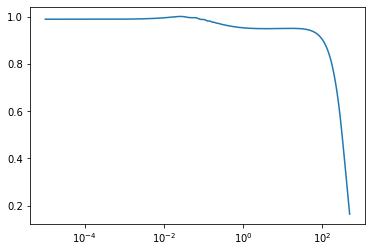

In [99]:
import matplotlib.pyplot as plt

plt.semilogx(k_arr, pk_lin_idm[-1, :]/pk_lin_lcdm[-1, :])

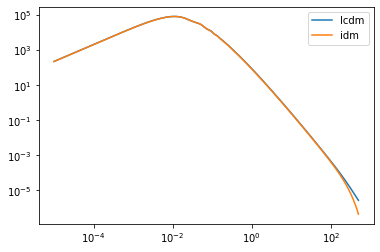

In [100]:
plt.loglog(k_arr, pk_lin_lcdm[-1, :], label='lcdm')
plt.loglog(k_arr, pk_lin_idm[-1, :], label='idm')
plt.legend()

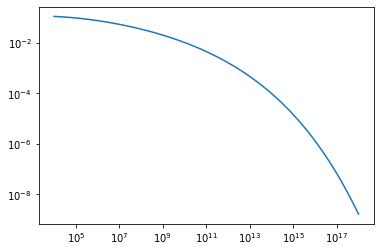

In [101]:
import matplotlib.pyplot as plt

# plt.loglog(Mgrid, dndm_lcdm)
# plt.loglog(Mgrid, dndm_idm)

Mgrid = np.logspace(4, 18, 100)
plt.loglog(Mgrid, dndm_idm/dndm_lcdm)

In [90]:
cosmo = pyccl.Cosmology(Omega_c=0.26030000000000003, Omega_b=0.0486, h=0.6774, n_s=0.9667, sigma8=0.8159, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

NameError: name 'pyccl' is not defined

In [91]:
import pyccl

In [92]:
cosmo = pyccl.Cosmology(Omega_c=0.26030000000000003, Omega_b=0.0486, h=0.6774, n_s=0.9667, sigma8=0.8159, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

AttributeError: 'MassFuncTinker08' object has no attribute 'cosmo'